In [1]:
# ======== importing modules ========
from pytransit import MandelAgol
import glob, os
from os import listdir
from os.path import isfile, join
import fnmatch
import matplotlib.pyplot as plt
from matplotlib import pylab
from pylab import *
import numpy as np
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=np.nan)
import pandas as pd

fs = 22; ms = 4 #fontsize, markersize

#========== Karen's inverse weighted binning function =======
def Bin_func(time,flux,error,binsize):
    import warnings
    warnings.filterwarnings("ignore")
    good = np.where(np.isfinite(time)) # finding where values are finite and "Not a Number (NaN)" or +/- infinite (inf)
    timefit = time[good] 
    fluxfit = flux[good] #using indices where values are finite, find where times, flux and errors are also finite
    errfit  = error[good]
    timemax = np.max(timefit) #find max time (or last time measurement)
    timemin = np.min(timefit) #find min time (or first time measurement)
    npoints = len(timefit)    #find number of data points
    nbins   = int(math.ceil((timemax - timemin)/binsize)) #binsize in days to nearest interger
    bintime = np.full((nbins,), np.nan) 
    binflux = np.full((nbins,), np.nan) #creating an empty array full of NaNs to fill in below
    binerr  = np.full((nbins,), np.nan)
    for i in range(0,nbins-1):
        tobin = [np.where( (timefit >= (timemin + i*binsize)) & (timefit < (timemin + (i+1)*binsize)) )] #with given binsize, searching over smaller areas (aka windows) (t-window) to (t+window)
        if tobin[0] != -1:
    #     inverse variance weighted means; read about here: https://en.wikipedia.org/wiki/Inverse-variance_weighting
    
            binflux[i] = ((fluxfit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            bintime[i] = ((timefit[tobin]/(errfit[tobin]**2.0)).sum()) / ((1.0/errfit[tobin]**2.0).sum())
            binerr[i]  = 1.0 / (np.sqrt( (1.0/errfit[tobin]**2.0)).sum() )
    
    good2   = np.where(np.isfinite(bintime)) #checking again for NaNs and infs that might be created by previous step
    bintime = bintime[good2]
    binflux = binflux[good2] 
    binerr  = binerr[good2]
    
    return bintime, binflux, binerr #here you have binned data with averaged values based on the bin sizes you've selected


def GLS(time,flux,fluxerror):
    from PyAstronomy.pyTiming import pyPeriod
    # Compute the GLS periodogram with default options.
    # Choose Zechmeister-Kuerster normalization explicitly
    
#     clp = pyPeriod.Gls((time, flux, fluxerror), norm="ZK", verbose=True)
    clp = pyPeriod.Gls((time, flux, fluxerror), norm="chisq", verbose=True)    

    # Get index associated with highest power
    ifmax = np.argmax(clp.power)
    # and highest power and associated frequency
    pmax = clp.power[ifmax]
    fmax = clp.freq[ifmax]
    # Convert frequency into period
    hpp = 1./fmax
#     print("Highest-power period: ", hpp)

    # Calculate sine wave associated with 'best-fit' frequency
    bestSine = clp.sinmod(time)
    
    return bestSine, 1./fmax

In [3]:
#------------------------------Finding Downloaded TESS Data Files --------------------------------------
path = '/Users/felizd/Desktop/Felix/TESSdata/Sector01/curves/clean' #location of where I put downloaded files

data = [os.path.join(dirpath, f) # an array of path names to be looped over
    for dirpath, dirnames, files in os.walk(path) #recursively searches through directory
    for f in fnmatch.filter(files, '*.lc')] #finds every file (*) that ends with .lc

print "number of files: ",len(data) #number of files

# for d in range(len(data)):
#     print "data set #", d+1 ," : ", data[d] #I added the d+1 because python does zero-indexing (https://en.wikipedia.org/wiki/Zero-based_numbering)
#     print ""

number of files:  10138


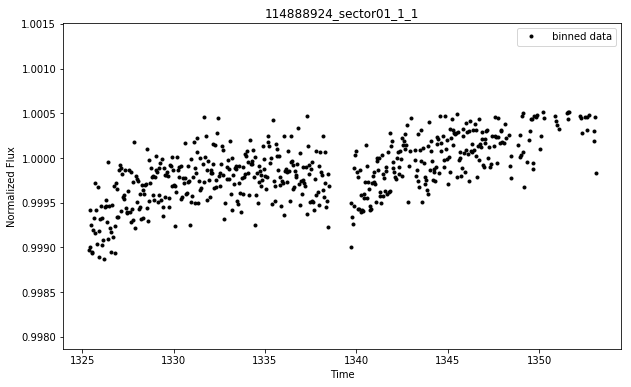

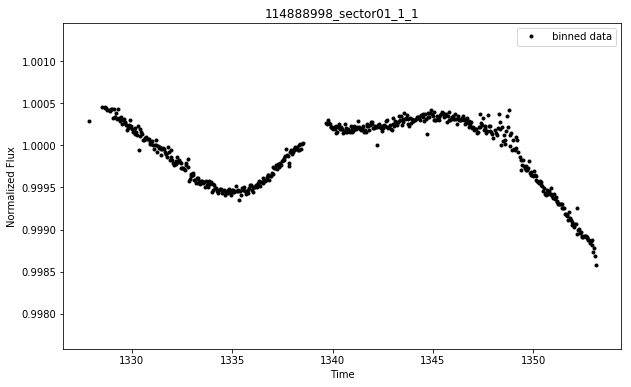

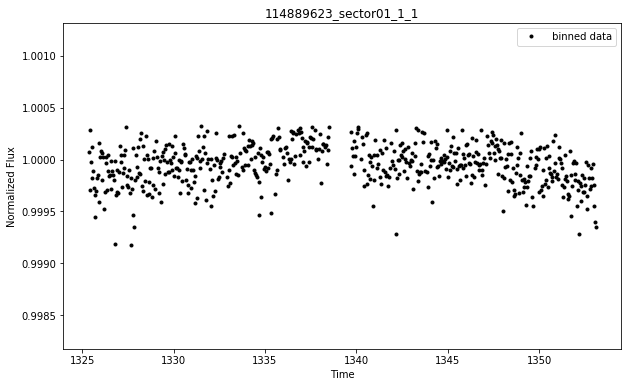

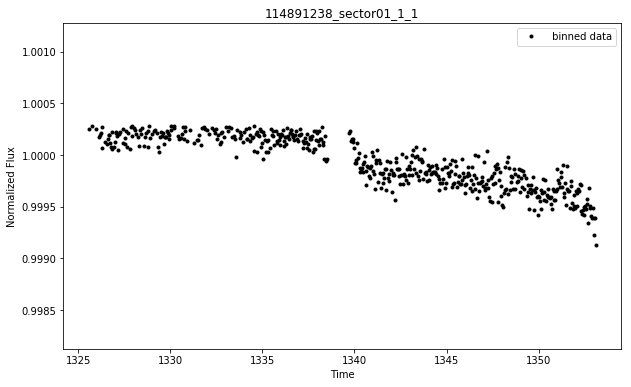

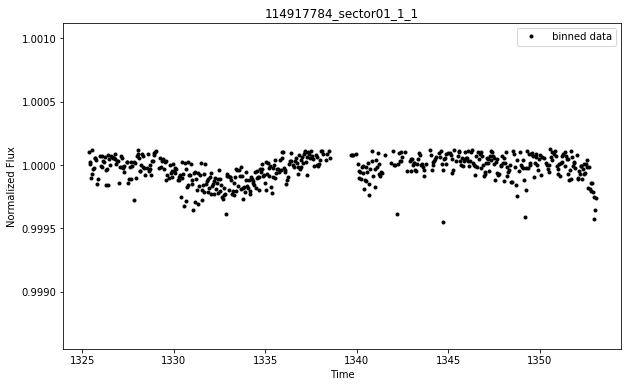

In [19]:

#now let's scale up our data reading and plotting commands to a for loop

def bin_and_clip(data,binsize,Nsig): #this definition simply bins the data and cuts out outliers

    d = np.transpose(np.loadtxt(data))
    t = d[0]
    m = d[1]/np.nanmean(d[1]) #normalized
    e = d[2]

    f = 10.0**(m/-2.5)/np.mean(10.0**(m/-2.5)) #converting from mag to flux and normalizing

    bint,binm,binfe = Bin_func(t,m,e, binsize) #binning data
    binf = 10.0**(binm/-2.5)/np.mean(10.0**(binm/-2.5))

    cut = np.where(binf< (np.mean(binf)+np.std(binf)))[0] #cutting ONLY data above 1 std above the mean

    return bint[cut],binf[cut],binfe[cut]
    
binsize = (1./24.0); Nsig=3.0

# for x in range(len(data)):
for x in range(5):
    bint,binf,binfe = bin_and_clip(data[x],binsize,Nsig)
    
    plt.figure(figsize=(10,6))
    plt.plot(bint,binf,marker='.',color='k',linestyle='none',label=" binned data")
    plt.xlabel("Time")
    plt.ylabel("Normalized Flux")
    plt.legend(loc='best') 
    # plt.gca().invert_yaxis()
    plt.ylim(np.min(binf)-0.001,np.max(binf)+0.001)
    plt.title(data[x][59:-3])
    plt.savefig(str(data[x][59:-3])+"_lightcurve.png")
    plt.show()
    
    
bint,binf,binfe = bin_and_clip(data[1],binsize,Nsig) #binning, clipping data
 
np.savetxt(str(data[1][59:-3])+"_binned.txt", zip(bint,binf,binfe)) #saving data
    

In [20]:
print "calculated BLS parameters"

duration = bint[-1] - bint[0] #last - first data point of light curve

#min, max periods:
Pmin = 1.01
Pmax =  31.0

#min, max fractional transit duration (q = transit duration / orbital period)
qmin = 0.01
qmax = 0.1

Nfreq = round(4.0*duration*(1./Pmin - 1./Pmax)/qmin,1) #number of frequencies to fix boxes to ; rounds to nearest decimal
Nbins = 2.0/qmin # number of phase bins to fold our data over
Npeaks = 4 #number of top peaks in power spectrum to report

print "duration of binned light curved:", duration
print "max, min orbital period: ", Pmin, Pmax
print "max, min fractional transit duration: ", qmin, qmax
print "number of frequencies: ", Nfreq
print "number of phase bins: ", Nbins

TIC = data[1][59:-3] #TESS ID number of this object

print " "
print ('sh BLS.sh '+str(data[1][59:-3])+"_binned.txt"+' '+str(qmin)+" "+str(qmax)+" "+str(Pmin)+" "+str(Pmax)+" "+str(Nfreq)+ " "+str(Nbins)+" "+str(Npeaks)+" "+str(TIC) ) 


os.system('sh BLS.sh '+str(data[1][59:-3])+"_binned.txt"+' '+str(qmin)+" "+str(qmax)+" "+str(Pmin)+" "+str(Pmax)+" "+str(Nfreq)+ " "+str(Nbins)+" "+str(Npeaks)+" "+str(TIC)) 

print ""
print "now to load in results"

calculated BLS parameters
duration of binned light curved: 25.260122227369948
max, min orbital period:  1.01 31.0
max, min fractional transit duration:  0.01 0.1
number of frequencies:  9678.1
number of phase bins:  200.0
 
sh BLS.sh 114888998_sector01_1_1_binned.txt 0.01 0.1 1.01 31.0 9678.1 200.0 4 114888998_sector01_1_1

now to load in results


printing top peaks and its orbital periods
16.34895496

1.25331665

1.1283203

1.08134195

plotting BLS power spectrum: 


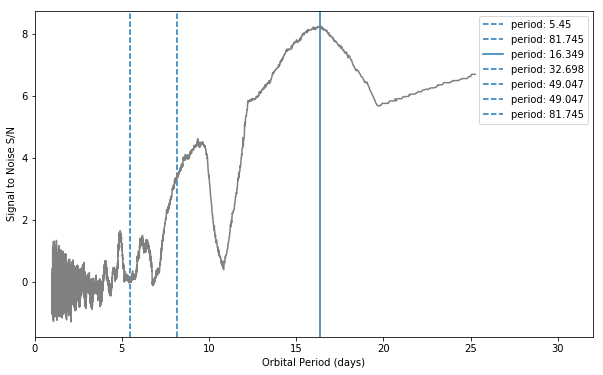

 phase folding
load in BLS model for top peak


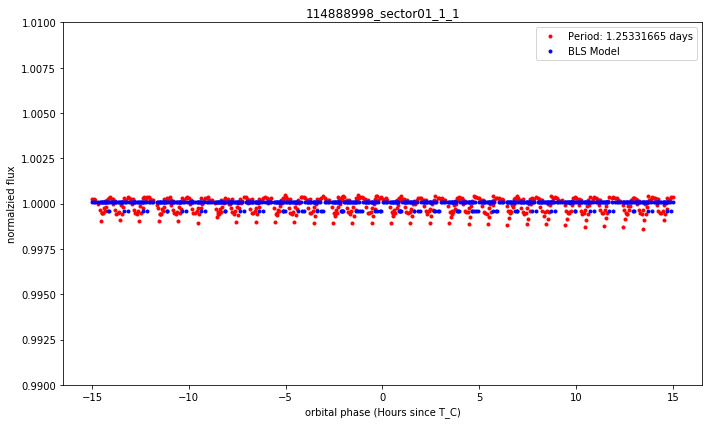

In [22]:
BLS_output = np.loadtxt(str(data[1][59:-3])+"_BLS_output.txt", usecols=[2], skiprows=1)

print "printing top peaks and its orbital periods"
for i in range(Npeaks): 
    print BLS_output[0::18][:-1][i]
    print ""
    
BLS_Period = np.transpose(np.loadtxt("outdir/"+str(TIC)+"_binned.txt.bls"))[0]
BLS_SN = np.transpose(np.loadtxt("outdir/"+str(TIC)+"_binned.txt.bls"))[1]

print "plotting BLS power spectrum: "

plt.figure(figsize=(10,6))
plt.plot(BLS_Period,BLS_SN,color='grey',zorder=1)
plt.xlabel("Orbital Period (days)")
plt.ylabel("Signal to Noise S/N")
plt.axvline(x=BLS_output[0::18][:-1][0]/3.,label = "period: "+str(np.round(BLS_output[0::18][:-1][0]/3.,3)),zorder=0,linestyle='--')
plt.axvline(x=BLS_output[0::18][:-1][0]/2.,label = "period: "+str(np.round(BLS_output[0::18][:-1][0]/.2,3)),zorder=0,linestyle='--')
plt.axvline(x=BLS_output[0::18][:-1][0],label = "period: "+str(np.round(BLS_output[0::18][:-1][0],3)),zorder=0,linestyle='-')
plt.axvline(x=2*BLS_output[0::18][:-1][0],label = "period: "+str(np.round(BLS_output[0::18][:-1][0]*2,3)),zorder=0,linestyle='--')
plt.axvline(x=3*BLS_output[0::18][:-1][0],label = "period: "+str(np.round(BLS_output[0::18][:-1][0]*3,3)),zorder=0,linestyle='--')
plt.axvline(x=4*BLS_output[0::18][:-1][0],label = "period: "+str(np.round(BLS_output[0::18][:-1][0]*3,3)),zorder=0,linestyle='--')
plt.axvline(x=5*BLS_output[0::18][:-1][0],label = "period: "+str(np.round(BLS_output[0::18][:-1][0]*5,3)),zorder=0,linestyle='--')
plt.xlim(0,32)
plt.legend(bbox_to_anchor=(1,1))
plt.show()



print" phase folding"
t0  = BLS_output[1::18][:-1][1]
p = BLS_output[0::18][:-1][1]
pf= ((bint - t0  + p/2.0) % p)- p/2.0


print "load in BLS model for top peak"

bls_model = np.transpose(np.loadtxt("outdir/"+str(TIC)+"_binned.txt.bls.model"))
time_model = bls_model[0]
mag_model = bls_model[2]
flux_model = 10.0**(mag_model/-2.5)/np.mean(10.0**(mag_model/-2.5))
phase_model = np.array(((time_model - t0  + p/2.0) % p)- p/2.0 )



# binf = 10.0**(binm/-2.5)/np.mean(10.0**(binm/-2.5))

plt.figure(figsize=(10,6))
plt.plot(24.*pf,binf,marker='.',c='r',linestyle='none',label='Period: '+str(p)+" days",zorder=0)
plt.plot(24.*phase_model,flux_model,marker='.',c='b',linestyle='none',label='BLS Model',zorder=1)
# plt.gca().invert_yaxis()
plt.ylabel("normalzied flux")
# plt.xlabel("orbital phase (JD since T_C)")
plt.xlabel("orbital phase (Hours since T_C)")
plt.ylim(0.99,1.01)
plt.title(str(TIC))
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig(str(TIC)+".png")
plt.show()


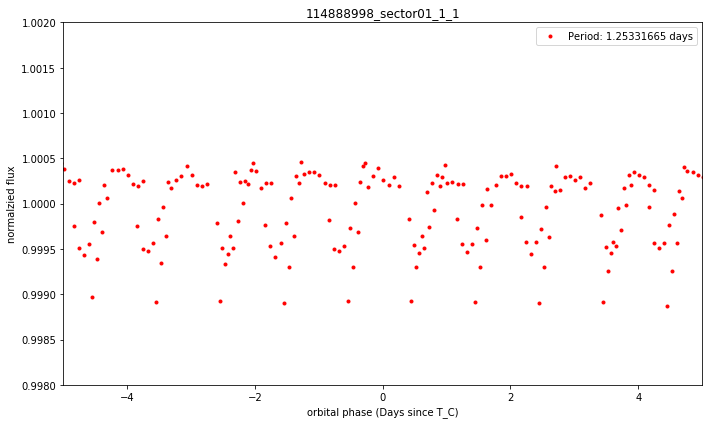

In [31]:
plt.figure(figsize=(10,6))
plt.plot(24.*pf,binf,marker='.',c='r',linestyle='none',label='Period: '+str(p)+" days",zorder=0)
# plt.plot(24.*phase_model,flux_model,marker='.',c='b',linestyle='none',label='BLS Model',zorder=1)
# plt.gca().invert_yaxis()
plt.ylabel("normalzied flux")
# plt.xlabel("orbital phase (JD since T_C)")
plt.xlabel("orbital phase (Days since T_C)")
plt.ylim(0.998,1.002)
plt.title(str(TIC))
plt.xlim(-5,5)
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout()

plt.show()

Assuming you have a transit depth, a stellar temperature, you can estimate a planet size based on a few relations, such as:

Stefan-Boltzmann Law
Mass-Luminosity Relation
Flux Ratio between star and planet

In [33]:

# print "estimating stellar radius"



# sig_SB = 5.67*10.0**(-5) #erg cm^-2 s^-1 K^-4 # called Stefan-Boltzmann constant

# M_sun = 1.99*10.0**33 #grams
# R_sun = 6.96*10.0**10 #cm
# T_sun = 5777 #kelvins
# L_sun= (4.0*np.pi*(R_sun**2.0))*(sig_SB*T_sun)

# L_star = L_sun * 10.0**( (4.85-7.821581616)/2.5 ); print L_star/L_sun, "solar luminosity"

# T_star = 4105.72 #K

# R_star  = R_sun * np.sqrt( ((T_sun/T_star)**4.0)*(L_star/L_sun)  )
# print R_star/R_sun, "solar radii"

# R_Earth = 6.37*10.**8 #cm
# R_planet = np.sqrt(depth)*R_star ; print R_planet/ R_Earth, "Earth radii"